### Force field - one component

#### Small molecule

Reading data	1.37 s
Preparing input	27.45 s


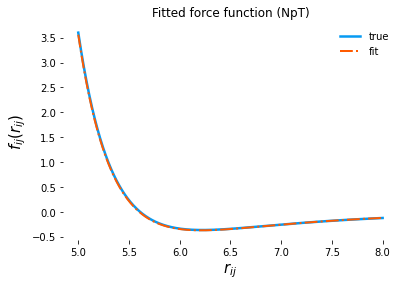

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from lj_test.data_processing_multi import DataProcessing

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/one_component_files/lj_trajectory_match_nve.out"
params = range(0, -15, -1)
simulation_timestep = 0.5

# These parameters affect the accuracy of the fit. 'steps' = {'NVE': 2/500, 'NpT': 1/500}
steps = 2
timesteps_in_fit = 500

proc = DataProcessing(outfile_path=outfile, simulation_timestep=simulation_timestep, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      evrey_n_from_output=steps, timesteps_in_fit=timesteps_in_fit)
proc.prepare_training_data()
proc.regress(method='bayesian')

x = np.linspace(5, 8, 1000)
y = proc.predict(x)[0]
y_ = 24 * 0.75 / x * (2 * (5/x) ** 12 - (5/x) ** 6)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_, label='true', lw=2.5, color='xkcd:azure')
ax.plot(x, y, label='fit', ls='-.', lw=2., color='xkcd:bright orange')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title(r"Fitted force function (NpT)")
ax.set_xlabel(r"$r_{ij}$", fontsize=15)
ax.set_ylabel(r"$f_{ij}(r_{ij})$", fontsize=15)
ax.legend(frameon=False)

#plt.savefig("lj_npt_fit.png", bbox_inches='tight')

#### Large molecule

Reading data	0.98 s
Preparing input	13.53 s


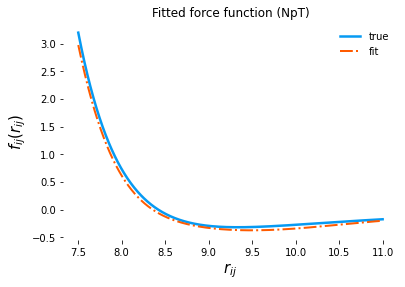

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from lj_test.data_processing_multi import DataProcessing

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/one_component_files/lj_trajectory_match_heavy_npt.out"
params = range(0, -15, -1)
simulation_timestep = 0.5

# These parameters affect the accuracy of the fit. 'steps' = {'NVE': 1/400, 'NpT': 2/400}
steps = 2
timesteps_in_fit = 400

proc = DataProcessing(outfile_path=outfile, simulation_timestep=simulation_timestep, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      evrey_n_from_output=steps, timesteps_in_fit=timesteps_in_fit)
proc.prepare_training_data()
proc.regress(method='bayesian')

x = np.linspace(7.5, 11, 1000)
y = proc.predict(x)[0]
y_ = 24 * 1.0 / x * (2 * (7.5/x) ** 12 - (7.5/x) ** 6)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_, label='true', lw=2.5, color='xkcd:azure')
ax.plot(x, y, label='fit', ls='-.', lw=2., color='xkcd:bright orange')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title(r"Fitted force function (NpT)")
ax.set_xlabel(r"$r_{ij}$", fontsize=15)
ax.set_ylabel(r"$f_{ij}(r_{ij})$", fontsize=15)
ax.legend(frameon=False)

plt.savefig("lj_large_npt_fit.png", bbox_inches='tight')

### Force field - two component

Reading data	2.32 s
Preparing input	37.26 s


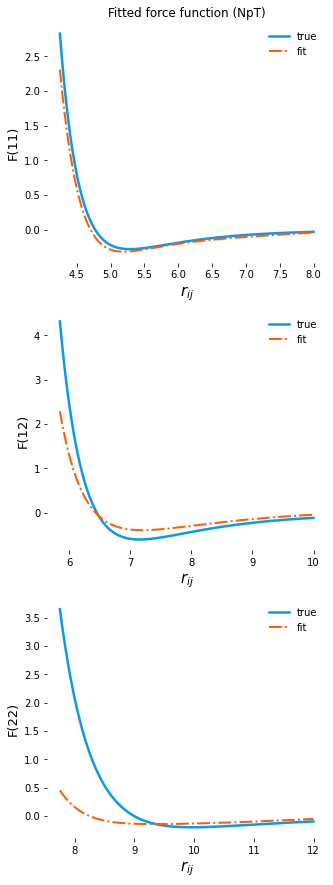

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from lj_test.data_processing_multi import DataProcessing

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/two_component_files/lj_trajectory_match_nve_large.out"
params = range(0, -14, -2)
steps =  30 # 30, 50
output_timestep = 0.5

proc = DataProcessing(outfile_path=outfile, timestep=output_timestep*steps, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      steps_between_points=steps, steps_used_in_fit=50)
proc.prepare_training_data()
proc.regress(method='bayesian')

X = [np.linspace(4.25, 8, 1000), np.linspace(5.85, 10, 1000), np.linspace(7.75, 12, 1000)]
y_0 = 24 * 0.50 / X[0] * (2 * (4.25/X[0]) ** 12 - (4.25/X[0]) ** 6)
y_1 = 24 * 1.45 / X[1] * (2 * (5.75/X[1]) ** 12 - (5.75/X[1]) ** 6)
y_2 = 24 * 1.00 / X[2] * (2 * (7.75/X[2]) ** 12 - (7.5/X[2]) ** 6)
Y_ = [y_0, y_1, y_2]
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
i = 0
types = ['11', '12', '22']
for force in [0, 1, 2]:
    x = X[force]
    y = proc.predict(x)[force]

    ax[i].plot(x, Y_[force], label='true', lw=2.5, color='xkcd:azure')
    ax[i].plot(x, y, label='fit', ls='-.', lw=2., color='xkcd:bright orange')
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    if i == 0:
        ax[i].set_title("Fitted force function (NpT)")
    ax[i].set_xlabel(r"$r_{ij}$", fontsize=15)
    ax[i].set_ylabel(f"F({types[i]})", fontsize=13)
    ax[i].legend(frameon=False)
    i += 1

plt.savefig(f"/home/markjenei/polymerisation-coarse-graining/lj_test/two_component_files/figs/two_component_nve_fit_{steps}.png", bbox_inches='tight')